## Response Ranking

 

# Preliminaries: Inspect and Set up environment

In [2]:
import datetime
print(datetime.datetime.now())

2025-07-27 12:03:45.761844


In [3]:
import sys
print(sys.executable)


c:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\venv_main\Scripts\python.exe


In [4]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 0. Data Loading and Inspection


# 0.1 Unzip and Load the Data

In [5]:
import zipfile
import py7zr
import pandas as pd
from pathlib import Path

import zipfile
from pathlib import Path

import zipfile
from pathlib import Path
import shutil
zip_path = r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\kkbox-churn-prediction-challenge.zip"


import zipfile
import py7zr
import pandas as pd
from pathlib import Path

def load_csvs_from_zip_of_7z(zip_path_str, temp_dir_str="unzipped_temp"):
    zip_path = Path(zip_path_str)
    temp_dir = Path(temp_dir_str)
    temp_dir.mkdir(parents=True, exist_ok=True)

    print(f"\n📦 Extracting .7z files from ZIP: {zip_path.name}")
    with zipfile.ZipFile(zip_path, 'r') as z:
        for name in z.namelist():
            if name.endswith('.7z'):
                print(f"→ Extracting {name}")
                z.extract(name, path=temp_dir)

    dfs = {}

    print("\n📂 Extracting .csv files from each .7z:")
    for seven_z_path in temp_dir.rglob("*.7z"):
        print(f"→ Unpacking: {seven_z_path.name}")
        inner_extract_dir = seven_z_path.with_suffix("")  # folder with same name
        inner_extract_dir.mkdir(exist_ok=True)

        try:
            with py7zr.SevenZipFile(seven_z_path, mode='r') as archive:
                archive.extractall(path=inner_extract_dir)
        except Exception as e:
            print(f"❌ Failed to extract {seven_z_path.name}: {e}")
            continue

        for csv_file in inner_extract_dir.glob("*.csv"):
            try:
                df = pd.read_csv(csv_file)
                key = csv_file.stem.lower()  # use file name without extension as key
                dfs[key] = df
                print(f"✓ Loaded {csv_file.name}, shape: {df.shape}")
            except Exception as e:
                print(f"⚠️ Failed to read {csv_file.name}: {e}")

    if not dfs:
        print("⚠️ No CSVs loaded. Check if the ZIP contains .7z files and they contain .csv files.")
    else:
        print(f"\n✅ Loaded {len(dfs)} CSV file(s): {list(dfs.keys())}")

    return dfs





In [ ]:
# dfs = load_csvs_from_zip_of_7z(
#     zip_path_str=r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\kkbox-churn-prediction-challenge.zip",
#     temp_dir_str=r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\data"
# )



📦 Extracting .7z files from ZIP: kkbox-churn-prediction-challenge.zip
→ Extracting members_v3.csv.7z
→ Extracting sample_submission_v2.csv.7z
→ Extracting sample_submission_zero.csv.7z
→ Extracting train.csv.7z
→ Extracting train_v2.csv.7z
→ Extracting transactions.csv.7z
→ Extracting transactions_v2.csv.7z
→ Extracting user_logs.csv.7z
→ Extracting user_logs_v2.csv.7z

📂 Extracting .csv files from each .7z:
→ Unpacking: members_v3.csv.7z
✓ Loaded members_v3.csv, shape: (6769473, 6)
→ Unpacking: sample_submission_v2.csv.7z
→ Unpacking: sample_submission_zero.csv.7z
✓ Loaded sample_submission_zero.csv, shape: (970960, 2)
→ Unpacking: train.csv.7z
✓ Loaded train.csv, shape: (992931, 2)
→ Unpacking: train_v2.csv.7z
→ Unpacking: transactions.csv.7z
✓ Loaded transactions.csv, shape: (21547746, 9)
→ Unpacking: transactions_v2.csv.7z
→ Unpacking: user_logs.csv.7z
✓ Loaded user_logs.csv, shape: (392106543, 9)
→ Unpacking: user_logs_v2.csv.7z

✅ Loaded 5 CSV file(s): ['members_v3', 'sample_sub

# 1.1 Load data 

In [76]:
df_train=pd.read_csv(r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\unzipped_temp\train_v2.csv\data\churn_comp_refresh\train_v2.csv")
df_transactions=pd.read_csv(r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\unzipped_temp\transactions_v2.csv\data\churn_comp_refresh\transactions_v2.csv")
df_member=pd.read_csv(r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\unzipped_temp\members_v3.csv\members_v3.csv")
df_user_logs=pd.read_csv(r"C:\Users\Owner\Documents\GitProjects\Campaign Response Ranking\unzipped_temp\user_logs_v2.csv\data\churn_comp_refresh\user_logs_v2.csv")

# 1.2  Aggregate User Behavior Logs Before Campaign Response




In [106]:
import pandas as pd

def prepare_training_data(df_transactions, df_train, df_user_logs, top_n=10):
    # Step 1: Get Top-N most frequent campaign combinations
    top_campaigns = (
        df_transactions
        .groupby(['payment_method_id', 'payment_plan_days', 'plan_list_price'])
        .size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
        .head(top_n)
    )
    top_campaigns['campaign_id'] = ['C' + str(i + 1) for i in range(len(top_campaigns))]

    # Step 2: Filter transactions to only those Top-N campaigns
    df_top = df_transactions.merge(
        top_campaigns.drop(columns='count'),
        on=['payment_method_id', 'payment_plan_days', 'plan_list_price'],
        how='inner'
    )

    # Step 3: Add churn label
    df_top = df_top.merge(df_train[['msno', 'is_churn']], on='msno', how='left')

    # Step 4: Create response label
    df_top['responded'] = (
        (df_top['is_cancel'] == 0) & (df_top['is_churn'] == 0)
    ).astype(int)

    # Step 5: Prepare user logs
    df_user_logs['date'] = pd.to_datetime(df_user_logs['date'], format='%Y%m%d')
    df_top['transaction_date'] = pd.to_datetime(df_top['transaction_date'], format='%Y%m%d')

    # Step 6: Join logs with transactions
    logs_matched = df_user_logs.merge(
        df_top[['msno', 'campaign_id', 'transaction_date']],
        on='msno',
        how='inner'
    )

    # Step 7: Keep only logs BEFORE transaction date
    logs_matched = logs_matched[logs_matched['date'] < logs_matched['transaction_date']]

    # Step 8: Aggregate log features
    user_features = logs_matched.groupby(['msno', 'campaign_id']).agg({
        'num_25': 'sum',
        'num_50': 'sum',
        'num_75': 'sum',
        'num_985': 'sum',
        'num_100': 'sum',
        'num_unq': 'mean',
        'total_secs': 'mean'
    }).reset_index()

    # Step 9: Final dataset = df_top + user behavior
    df_final = df_top.merge(user_features, on=['msno', 'campaign_id'], how='left')

    return df_final


In [107]:
df_model = prepare_training_data(df_transactions, df_train, df_user_logs, top_n=10)


# STEP 2 EDA 

In [113]:
df_model
target_feature = 'responded'

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,campaign_id,is_churn,responded,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-08-09,20190412,0,C2,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,2017-03-03,20170422,0,C4,0.0,1,3.0,2.0,0.0,0.0,11.0,7.000000,1511.913000
2,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,2017-03-29,20170331,1,C4,1.0,0,78.0,49.0,41.0,14.0,357.0,29.642857,7407.521429
3,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,2017-03-23,20170423,0,C1,0.0,1,181.0,32.0,27.0,41.0,917.0,30.136364,10265.056273
4,+0KcMm8JNCW08lTp3Lyz5Ger/47u3yj9H2xLf8lyAj8=,41,30,149,149,1,2015-11-12,20180613,0,C2,0.0,1,4.0,0.0,0.0,1.0,65.0,9.857143,2183.582857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141427,zunw3CPwPJTzf7oIFzjoaukmM/rEGU3S1uIr/G2aY1I=,39,30,149,149,1,2017-02-28,20170404,0,C3,0.0,1,44.0,9.0,5.0,7.0,421.0,16.947368,4735.678105
1141428,zviO0RLvsXAzgz894wMm5b9Nxp8yxFAuqHY1Nq0lq3M=,36,30,180,180,1,2017-03-16,20170415,0,C4,0.0,1,17.0,4.0,5.0,2.0,567.0,38.538462,10447.788615
1141429,zx/h5MzQQmsSat04wSfGpHp6N8aWLLwM1+7OV7ujmPY=,41,30,149,149,1,2017-03-06,20170406,0,C2,0.0,1,0.0,0.0,0.0,0.0,14.0,14.000000,3019.410000
1141430,zxvgjIKjy18Fm+cIWUfYKr68z09+ILBxuMW0DnbeUZ8=,41,30,99,99,1,2017-03-08,20170408,0,C1,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141432 entries, 0 to 1141431
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   msno                    1141432 non-null  object        
 1   payment_method_id       1141432 non-null  int64         
 2   payment_plan_days       1141432 non-null  int64         
 3   plan_list_price         1141432 non-null  int64         
 4   actual_amount_paid      1141432 non-null  int64         
 5   is_auto_renew           1141432 non-null  int64         
 6   transaction_date        1141432 non-null  datetime64[ns]
 7   membership_expire_date  1141432 non-null  int64         
 8   is_cancel               1141432 non-null  int64         
 9   campaign_id             1141432 non-null  object        
 10  is_churn                998896 non-null   float64       
 11  responded               1141432 non-null  int64         
 12  num_25        

In [114]:
df_model.describe().T

,count,mean,min,25%,50%,75%,max,std
payment_method_id,1141432.0,39.662617,32.0,39.0,41.0,41.0,41.0,2.2041
payment_plan_days,1141432.0,44.65892,30.0,30.0,30.0,30.0,410.0,73.181352
plan_list_price,1141432.0,194.327646,99.0,99.0,149.0,149.0,1788.0,320.377572
actual_amount_paid,1141432.0,194.121927,0.0,99.0,149.0,149.0,1788.0,320.438643
is_auto_renew,1141432.0,0.889115,0.0,1.0,1.0,1.0,1.0,0.31399
transaction_date,1141432,2017-01-30 15:32:20.198627840,2015-01-01 00:00:00,2017-03-03 00:00:00,2017-03-13 00:00:00,2017-03-23 00:00:00,2017-03-31 00:00:00,NaN
membership_expire_date,1141432.0,20170958.208303,20160419.0,20170409.0,20170418.0,20170427.0,20281206.0,2868.483245
is_cancel,1141432.0,0.027206,0.0,0.0,0.0,0.0,1.0,0.162684
is_churn,998896.0,0.082657,0.0,0.0,0.0,0.0,1.0,0.275364
responded,1141432.0,0.792118,0.0,1.0,1.0,1.0,1.0,0.405792


In [115]:
df_model.describe(include=object).T

,count,unique,top,freq
msno,1141432,950531,Cb4XS2qU2qnJ5f5iUaWIGOnVf1QWDtq1gYBZ9CRs8yU=,63
campaign_id,1141432,10,C1,407750


In [116]:
# How much missing data is in each feature?

df_model.isna().sum()

msno                           0
payment_method_id              0
payment_plan_days              0
plan_list_price                0
actual_amount_paid             0
is_auto_renew                  0
transaction_date               0
membership_expire_date         0
is_cancel                      0
campaign_id                    0
is_churn                  142536
responded                      0
num_25                    426559
num_50                    426559
num_75                    426559
num_985                   426559
num_100                   426559
num_unq                   426559
total_secs                426559
dtype: int64

Taking a look at the class imbalance of our target

No response: 237283
Has response: 904149
training_data_pos_scale_weight: 0.2624379388795431


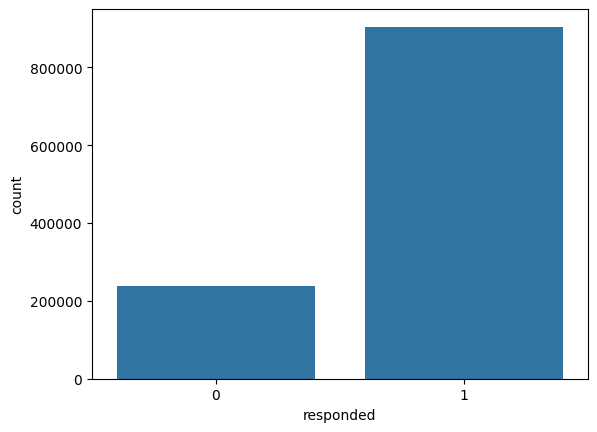

In [122]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

def get_target_skew_rate(data_target):
    target_df = pd.DataFrame(data_target)
    sns.countplot(x=target_feature, data=target_df)

    no_vaccine_count = len(target_df[target_df[target_feature]==0])
    yes_vaccine_count = len(target_df[target_df[target_feature]==1])
    print(f"No response: {no_vaccine_count}")
    print(f"Has response: {yes_vaccine_count}")

    # save this for later...
    training_data_pos_scale_weight = (no_vaccine_count / yes_vaccine_count)
    print(f"training_data_pos_scale_weight: {training_data_pos_scale_weight}")
    return training_data_pos_scale_weight

training_data_pos_scale_weight = get_target_skew_rate(df_model[target_feature])

In [124]:
df_model.dtypes

msno                              object
payment_method_id                  int64
payment_plan_days                  int64
plan_list_price                    int64
actual_amount_paid                 int64
is_auto_renew                      int64
transaction_date          datetime64[ns]
membership_expire_date             int64
campaign_id                       object
responded                          int64
num_25                           float64
num_50                           float64
num_75                           float64
num_985                          float64
num_100                          float64
num_unq                          float64
total_secs                       float64
dtype: object

In [132]:
# category columns and number columns
numerical_cols = df_model.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
categorical_cols = df_model.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()  

numerical_cols

['payment_method_id',
 'payment_plan_days',
 'plan_list_price',
 'actual_amount_paid',
 'is_auto_renew',
 'membership_expire_date',
 'responded',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs']

# 3. Preprocessing

In [119]:
feature_cols = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
df_model[feature_cols] = df_model[feature_cols].fillna(0)

df_model.drop(columns=['is_churn', 'is_cancel'], inplace=True, errors='ignore')

In [120]:

df_model.isna().sum()

msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
campaign_id               0
responded                 0
num_25                    0
num_50                    0
num_75                    0
num_985                   0
num_100                   0
num_unq                   0
total_secs                0
dtype: int64

# 2.3 Imputation

# 2.4 transformation

# 2.5 feature